In [9]:
# === Multi-horizon AQI with Random Forest (no Optuna) ===
from pathlib import Path
import json
import warnings
warnings.filterwarnings("ignore")

# ----------------- Imports -----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import joblib

# SHAP (install if needed)
try:
    import shap
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap


In [10]:

# ----------------- CONFIG -----------------
PROJECT_ROOT  = Path.cwd().parent
DATA_PATH     = PROJECT_ROOT / "preprocessed_aqi_data (3).csv"
FEATURES_JSON = PROJECT_ROOT / "final_feature_list.json"

OUT_DIR       = PROJECT_ROOT / "predictions"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_FILE   = OUT_DIR / "rf_predicted_aqi_72hrs.csv"

WINDOW_SIZE     = 24
PREDICT_HORIZON = 72
TARGET_COL      = "us_aqi"
TIME_COL_CANDS  = ["time", "datetime"]

RANDOM_SEED     = 42
np.random.seed(RANDOM_SEED)


In [11]:

# ------------------- LOAD & PARSE TIME -------------------
df = pd.read_csv(DATA_PATH)

for c in TIME_COL_CANDS:
    if c in df.columns:
        TIME_COL = c
        break
else:
    raise ValueError(f"No datetime column found. Expected one of: {TIME_COL_CANDS}")

raw_time = (
    df[TIME_COL].astype(str)
      .str.strip()
      .str.replace("\u00A0", " ", regex=False)
      .str.replace("\u202F", " ", regex=False)
)
df[TIME_COL] = pd.to_datetime(raw_time, dayfirst=True, errors="coerce")
df = df.sort_values(TIME_COL).reset_index(drop=True)


In [12]:

# ------------------- FEATURES -------------------
feat_cols = json.loads(FEATURES_JSON.read_text())
missing = [c for c in feat_cols + [TARGET_COL, TIME_COL] if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in data: {missing}")


In [13]:

# ------------------- TRAIN-ONLY WINSORIZATION + IMPUTE -------------------
def build_windows_limit(frame, features, target, window, horizon):
    return len(frame) - window - horizon

limit = build_windows_limit(df, feat_cols, TARGET_COL, WINDOW_SIZE, PREDICT_HORIZON)
if limit <= 0:
    raise ValueError("Not enough rows to make sliding windows. Add more data.")

train_windows = int(limit * 0.8)
raw_end_for_train_inputs = max((train_windows - 1) + WINDOW_SIZE, WINDOW_SIZE)

numeric_feats = [c for c in feat_cols if pd.api.types.is_numeric_dtype(df[c])]
low = df.loc[:raw_end_for_train_inputs, numeric_feats].quantile(0.01).to_dict()
high = df.loc[:raw_end_for_train_inputs, numeric_feats].quantile(0.99).to_dict()
for c in numeric_feats:
    df[c] = df[c].clip(lower=low[c], upper=high[c])

train_medians = df.loc[:raw_end_for_train_inputs, feat_cols].median(numeric_only=True).to_dict()
df[feat_cols] = df[feat_cols].fillna(train_medians)


In [14]:

# ------------------- BUILD SUPERVISED WINDOWS -------------------
def build_windows_flat(frame, features, target, window, horizon):
    base_cols = [target] + features
    lagged, x_colnames = [], []
    for lag in range(window, 0, -1):
        part = frame[base_cols].shift(lag)
        part.columns = [f"{c}_t-{lag}" for c in base_cols]
        lagged.append(part)
        x_colnames.extend(part.columns.tolist())
    X_df = pd.concat(lagged, axis=1)

    Y_df = pd.concat(
        [frame[target].shift(-h) for h in range(1, horizon+1)],
        axis=1
    )
    Y_df.columns = [f"{target}_t+{h}" for h in range(1, horizon+1)]

    full = pd.concat([X_df, Y_df], axis=1).dropna()
    return full[X_df.columns].values, full[Y_df.columns].values, full.index, x_colnames, Y_df.columns.tolist()

X, Y, idx, Xcols, Ycols = build_windows_flat(df, feat_cols, TARGET_COL, WINDOW_SIZE, PREDICT_HORIZON)


In [15]:

# ------------------- TRAIN/VAL SPLIT -------------------
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=False)
H = y_val.shape[1]

# ------------------- Metrics helpers -------------------
def metrics_block(y_t, y_p, label):
    mae  = mean_absolute_error(y_t, y_p)
    rmse = mean_squared_error(y_t, y_p, squared=False)
    r2s  = [r2_score(y_t[:, h], y_p[:, h]) for h in range(H)]
    print(f"\n=== {label} Metrics (averaged over {H} horizons) ===")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²:   {np.mean(r2s):.3f}")
    mae_list  = [mean_absolute_error(y_t[:, h], y_p[:, h]) for h in range(H)]
    if H >= 12: print(f"First 12 horizons MAE: {[round(m,3) for m in mae_list[:12]]}")
    if H >= 24: print(f"24h MAE: {mae_list[23]:.3f}")
    if H >= 48: print(f"48h MAE: {mae_list[47]:.3f}")
    if H >= 72: print(f"72h MAE: {mae_list[71]:.3f}")
    return mae_list, r2s


In [18]:

# ------------------- TRAIN RF -------------------
base_rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=None,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    bootstrap=True
)
rf = MultiOutputRegressor(base_rf, n_jobs=-1)
rf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(max_features=None,
                                                     n_estimators=400,
                                                     n_jobs=-1,
                                                     random_state=42),
                     n_jobs=-1)

In [19]:

# ------------------- EVAL -------------------
train_mae_list, train_r2_list = metrics_block(y_train, rf.predict(X_train), "Train")
val_mae_list,   val_r2_list   = metrics_block(y_val,   rf.predict(X_val),   "Validation")

pd.DataFrame({
    "horizon": np.arange(1, H+1),
    "MAE": val_mae_list,
    "R2":  val_r2_list
}).to_csv(OUT_DIR / "rf_val_per_horizon_metrics.csv", index=False)



=== Train Metrics (averaged over 72 horizons) ===
MAE:  0.929
RMSE: 1.452
R²:   0.988
First 12 horizons MAE: [0.31, 0.337, 0.356, 0.387, 0.412, 0.446, 0.486, 0.519, 0.54, 0.567, 0.601, 0.629]
24h MAE: 0.959
48h MAE: 1.050
72h MAE: 1.064

=== Validation Metrics (averaged over 72 horizons) ===
MAE:  7.576
RMSE: 8.928
R²:   -1.985
First 12 horizons MAE: [0.581, 0.748, 0.894, 1.046, 1.2, 1.383, 1.605, 1.816, 2.032, 2.327, 2.569, 2.803]
24h MAE: 5.724
48h MAE: 9.387
72h MAE: 13.513


In [20]:

# ------------------- FORECAST NEXT 72 HOURS -------------------
def build_one_feature_row_flat(df_all, features, target, window, xcols):
    need = df_all.iloc[-window:]
    base_cols = [target] + features
    parts = []
    for lag in range(window, 0, -1):
        row = need.iloc[-lag][base_cols]
        row.index = [f"{c}_t-{lag}" for c in base_cols]
        parts.append(row)
    row = pd.concat(parts)
    return row.reindex(xcols).values.reshape(1, -1)

X_future = build_one_feature_row_flat(df, feat_cols, TARGET_COL, WINDOW_SIZE, Xcols)
y_future = rf.predict(X_future)[0]

last_valid_time = df.loc[df[TIME_COL].notna(), TIME_COL].iloc[-1]
start = last_valid_time.floor("H") + pd.Timedelta(hours=1)
future_times = pd.date_range(start=start, periods=PREDICT_HORIZON, freq="h")

ft = pd.Series(future_times)
formatted_dt = (
    ft.dt.day.astype(str) + "/" +
    ft.dt.month.astype(str) + "/" +
    ft.dt.strftime("%y") + " " +
    ft.dt.strftime("%H:%M")
)

forecast_df = pd.DataFrame({
    "datetime": formatted_dt,
    "predicted_aqi_us": y_future
})
forecast_df.to_csv(OUTPUT_FILE, index=False)
print(f"\nSaved forecast → {OUTPUT_FILE}")
print("First/last timestamps:", forecast_df['datetime'].iloc[0], "→", forecast_df['datetime'].iloc[-1])



Saved forecast → d:\Desktop\AlinasPrograms\myenv\10Pearls2\predictions\rf_predicted_aqi_72hrs.csv
First/last timestamps: 10/8/25 00:00 → 12/8/25 23:00


In [21]:

# ------------------- SAVE MODEL + METADATA -------------------
SAVE_DIR = PROJECT_ROOT / "models" / "current"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH   = SAVE_DIR / "rf_multioutput_72h.joblib"
META_PATH    = SAVE_DIR / "metadata_rf.json"

joblib.dump(rf, MODEL_PATH)

meta = {
    "features": feat_cols,
    "target_col": TARGET_COL,
    "time_col": TIME_COL,
    "window_size": WINDOW_SIZE,
    "horizon": PREDICT_HORIZON,
    "dayfirst": True,
    "winsor_low": low,
    "winsor_high": high,
    "train_medians": train_medians
}
Path(META_PATH).write_text(json.dumps(meta, indent=2))
print("Saved model   →", MODEL_PATH)
print("Saved metadata→", META_PATH)


Saved model   → d:\Desktop\AlinasPrograms\myenv\10Pearls2\models\current\rf_multioutput_72h.joblib
Saved metadata→ d:\Desktop\AlinasPrograms\myenv\10Pearls2\models\current\metadata_rf.json


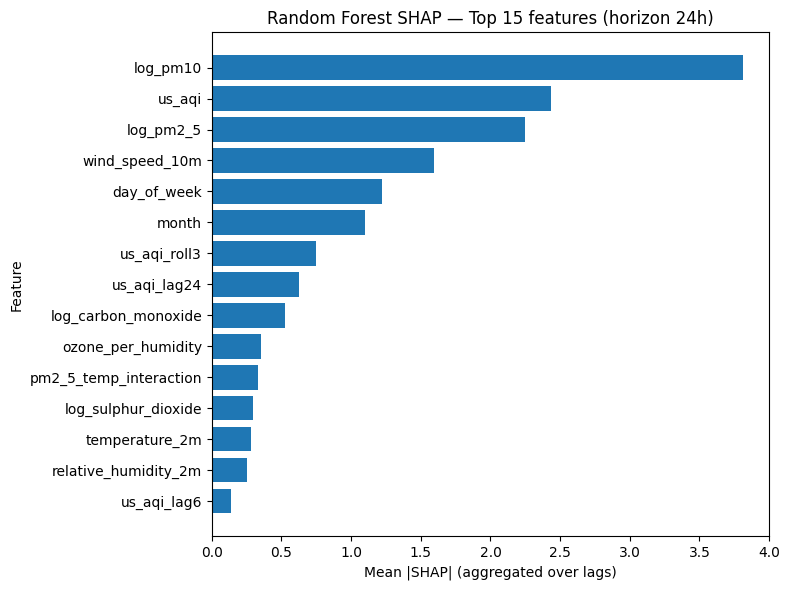

Saved aggregated SHAP importances → d:\Desktop\AlinasPrograms\myenv\10Pearls2\predictions\rf_shap_importance_aggregated.csv


In [22]:

# ------------------- SHAP FEATURE IMPORTANCE -------------------
h_for_shap = min(24, H) - 1
rf_h = rf.estimators_[h_for_shap]

n_sample = min(800, X_val.shape[0])
Xv_sample = X_val[-n_sample:]

explainer = shap.TreeExplainer(rf_h)
shap_values = explainer.shap_values(Xv_sample)

mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({"feature_flat": Xcols, "mean_abs_shap": mean_abs_shap})

def base_name(flat_name: str) -> str:
    return flat_name.split("_t-")[0] if "_t-" in flat_name else flat_name

shap_df["base_feature"] = shap_df["feature_flat"].map(base_name)
agg = shap_df.groupby("base_feature")["mean_abs_shap"].sum().sort_values(ascending=False).reset_index()

TOP_K = 15
topk = agg.head(TOP_K)

plt.figure(figsize=(8, 6))
plt.barh(topk["base_feature"][::-1], topk["mean_abs_shap"][::-1])
plt.xlabel("Mean |SHAP| (aggregated over lags)")
plt.ylabel("Feature")
plt.title(f"Random Forest SHAP — Top {TOP_K} features (horizon {h_for_shap+1}h)")
plt.tight_layout()
plt.show()

agg.to_csv(OUT_DIR / "rf_shap_importance_aggregated.csv", index=False)
print("Saved aggregated SHAP importances →", OUT_DIR / "rf_shap_importance_aggregated.csv")
